In [1]:
!pip install autogluon.multimodal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runti

In [1]:
import os
import warnings
from IPython.display import Image, display
import numpy as np
warnings.filterwarnings('ignore')
np.random.seed(123)

In [2]:
from autogluon.core.utils.loaders import load_pd
import pandas as pd
download_dir = './ag_automm_tutorial_imgtxt'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/flickr30k.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

100%|██████████| 4.38G/4.38G [04:04<00:00, 17.9MiB/s]


In [3]:
!pip install --upgrade torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.1
    Uninstalling torchvision-0.18.1:
      Successfully uninstalled torchvision-0.18.1
ERR

In [4]:
dataset_path = os.path.join(download_dir, 'flickr30k_processed')
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
val_data = pd.read_csv(f'{dataset_path}/val.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
image_col = "image"
text_col = "caption"

In [5]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
val_data[image_col] = val_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

In [6]:
train_data.head()

,caption,image
0,Two young guys with shaggy hair look at their ...,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
1,Two young White males are outside near many bu...,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
2,Two men in green shirts are standing in a yard,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
3,A man in a blue shirt standing in a garden,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
4,Two friends enjoy time spent together,/content/ag_automm_tutorial_imgtxt/flickr30k_p...


In [7]:
[ ]
train_data[text_col][0]


'Two young guys with shaggy hair look at their hands while hanging out in the yard'

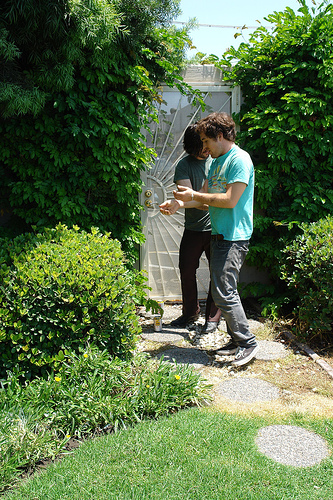

In [8]:
pil_img = Image(filename=train_data[image_col][0])
display(pil_img)

In [9]:
test_image_data = pd.DataFrame({image_col: test_data[image_col].unique().tolist()})
test_text_data = pd.DataFrame({text_col: test_data[text_col].unique().tolist()})
test_data_with_label = test_data.copy()
test_label_col = "relevance"
test_data_with_label[test_label_col] = [1] * len(test_data)

In [10]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(
            query=text_col,
            response=image_col,
            problem_type="image_text_similarity",
            eval_metric="recall",
        )

In [11]:
txt_to_img_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_text_data,
            response_data=test_image_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
img_to_txt_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_image_data,
            response_data=test_text_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
print(f"txt_to_img_scores: {txt_to_img_scores}")
print(f"img_to_txt_scores: {img_to_txt_scores}")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

txt_to_img_scores: {'recall@1': 0.58964, 'recall@5': 0.83533, 'recall@10': 0.90156}
img_to_txt_scores: {'recall@1': 0.15525, 'recall@5': 0.5708, 'recall@10': 0.7172}


In [12]:
predictor.fit(
            train_data=train_data,
            tuning_data=val_data,
            time_limit=180,
        )

No path specified. Models will be saved in: "AutogluonModels/ag-20240918_073238"
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.4.1+cu121
CUDA Version:       12.1
Memory Avail:       9.05 GB / 12.67 GB (71.4%)
Disk Space Avail:   61.14 GB / 112.64 GB (54.3%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/AutogluonModels/ag-20240918_073238
    ```

INFO: Seed set to 0
GPU Count: 1
GPU Count to be Used: 1
GPU 0 Name: Tesla T4
GPU 0 Memory: 0.38GB/15.0GB (Used/Total)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 133: 'val_recall' reached 0.52719 (best 0.52719), saving model to '/content/AutogluonModels/ag-20240918_073238/epoch=0-step=133.ckpt' as top 3
Start to fuse 1 checkpoints via the greedy soup algorithm.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20240918_073238")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [13]:
txt_to_img_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_text_data,
            response_data=test_image_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
img_to_txt_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_image_data,
            response_data=test_text_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
print(f"txt_to_img_scores: {txt_to_img_scores}")
print(f"img_to_txt_scores: {img_to_txt_scores}")

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

txt_to_img_scores: {'recall@1': 0.64646, 'recall@5': 0.87575, 'recall@10': 0.92657}
img_to_txt_scores: {'recall@1': 0.16005, 'recall@5': 0.623, 'recall@10': 0.7724}


In [14]:
pred = predictor.predict(test_data.head(5))
print(pred)

Predicting: |          | 0/? [00:00<?, ?it/s]

0    1
1    1
2    1
3    1
4    1
dtype: int64


In [15]:
proba = predictor.predict_proba(test_data.head(5))
print(proba)

Predicting: |          | 0/? [00:00<?, ?it/s]

          0         1
0  0.351420  0.648580
1  0.325705  0.674295
2  0.353323  0.646677
3  0.349855  0.650145
4  0.338130  0.661870


In [16]:
image_embeddings = predictor.extract_embedding({image_col: test_image_data[image_col][:5].tolist()})
print(image_embeddings.shape)

Predicting: |          | 0/? [00:00<?, ?it/s]

(5, 512)


In [17]:
text_embeddings = predictor.extract_embedding({text_col: test_text_data[text_col][:5].tolist()})
print(text_embeddings.shape)

Predicting: |          | 0/? [00:00<?, ?it/s]

(5, 512)


In [18]:
from autogluon.multimodal.utils import semantic_search
text_to_image_hits = semantic_search(
        matcher=predictor,
        query_data=test_text_data.iloc[[3]],
        response_data=test_image_data,
        top_k=5,
    )

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [19]:
test_text_data.iloc[[3]]

,caption
3,A man in an orange hat starring at something


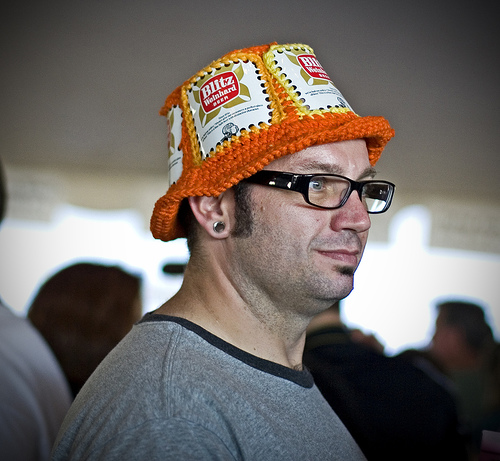

In [20]:
pil_img = Image(filename=test_image_data[image_col][text_to_image_hits[0][0]['response_id']])
display(pil_img)

In [21]:
image_to_text_hits = semantic_search(
        matcher=predictor,
        query_data=test_image_data.iloc[[6]],
        response_data=test_text_data,
        top_k=5,
    )

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]